In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import matplotlib.pyplot as plt

from discriminator import Discriminator
from generator import Generator

from torch.utils.data import DataLoader, Dataset


from utils import *
import torchvision
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from datasets import HorseDataset
from datasets import ZebraDataset

from utils import *

BATCH_SIZE = 1
IMAGE_SIZE = 256

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

TRAIN_DIR = "/ssd_scratch/cvit/anirudhkaushik/datasets/cyclegan/horse2zebra/horse2zebra"
VAL_DIR = "/ssd_scratch/cvit/anirudhkaushik/datasets/cyclegan/horse2zebra/horse2zebra"

dataset = HorseDataset(
    root_horse=TRAIN_DIR + "/trainA",
    transform=data_transforms,
)
val_dataset = HorseDataset(
    root_horse=VAL_DIR + "/testA",
    transform=data_transforms,
)

dataset2 = ZebraDataset(
    root_zebra=TRAIN_DIR + "/trainB",
    transform=data_transforms,
)
val_dataset2 = ZebraDataset(
    root_zebra=VAL_DIR + "/testB",
    transform=data_transforms,
)

def generate_real_images( n_samples, patch_shape):
    y = np.ones((n_samples, 1, patch_shape, patch_shape))
    y = torch.FloatTensor(y)
    return  y

def generate_fake_images(model, dataset, patch_shape ):
    X = model(dataset)
    y = np.zeros((len(X), 1, patch_shape, patch_shape, ))
    y = torch.FloatTensor(y)
    return X, y


In [2]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader2 = DataLoader(dataset2, batch_size=BATCH_SIZE, shuffle=True)

In [3]:

def visualize(dataloader, dataloader2,  netG, netD, criterion, epoch, fixed_noise, device):
    real1 = dataloader
    real2 = dataloader2

    for i, (X_real1, X_real2) in enumerate(zip(real1, real2)):
        break

    
    X_real1 = X_real1.to(device)
    X_real2 = X_real2.to(device)
    
    # fake, _ = generate_fake_images(netG, X_real1, 1)
    fake,_ = generate_fake_images(netG, X_real1, 1)
    

    

    # Plot the fake images from the last epoch

    fake = (fake - fake.min())/ (fake.max() - fake.min())
    # for row in range(8):
    #     for col in range(8):
    #         plt.subplot(8, 8, row*8+col+1)
    #         plt.axis("off")
    #         # set subplot label to be the label of the image
    #         plt.title(y_labels[row*8+col].item())
    #         # make title fit properly
    #         plt.subplots_adjust(top=1.5)
    #         # correct for mean 0 and std 1
    #         # unnormalize
    #         # adjust to 0 to 1 range
    #         plt.imshow(fake[row*8+col].detach().cpu().numpy().transpose(1,2,0), cmap='gray')


    return X_real1, fake

In [4]:

IMG_SIZE = 256
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
img_list = []
import glob
for checkpointD1, checkpointG1, checkpointD2, checkpointG2 in sorted(list(zip(glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/cycle_ganD1_checkpoint_*.pt"),glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/cycle_ganG1_checkpoint_*.pt"), glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/cycle_ganD2_checkpoint_*.pt"),glob.glob("/ssd_scratch/cvit/anirudhkaushik/checkpoints/cycle_ganG2_checkpoint_*.pt")))):
    print("epoch :" + checkpointD1.split("_")[-2].split(".")[0])
    
    checkpointD1 = torch.load(checkpointD1)
    checkpointG1 = torch.load(checkpointG1)
    checkpointD2 = torch.load(checkpointD2)
    checkpointG2 = torch.load(checkpointG2)

    modelG1 = Generator(256, 3)
    modelD1 = Discriminator(3)
    modelG1.load_state_dict(checkpointG1['model'])
    modelD1.load_state_dict(checkpointD1['model'])

    modelG1 = modelG1.to(device)
    modelD1 = modelD1.to(device)

    modelG2 = Generator(256, 3)
    modelD2 = Discriminator(3)
    modelG2.load_state_dict(checkpointG2['model'])
    modelD2.load_state_dict(checkpointD2['model'])

    modelG2 = modelG2.to(device)
    modelD2 = modelD2.to(device)





    # visualize
    criterion = nn.MSELoss()

    real, fake = visualize(dataloader, dataloader2, modelG1, modelD1, criterion, 0, fixed_noise, device)
    real2, fake2 = visualize(dataloader2, dataloader, modelG2, modelD2, criterion, 0, fixed_noise, device)
    img_list.append(vutils.make_grid(torch.concat((real, fake, real2, fake2), dim=0 ), padding=0, normalize=True))


epoch :0
epoch :1
epoch :2
epoch :3
epoch :checkpoint


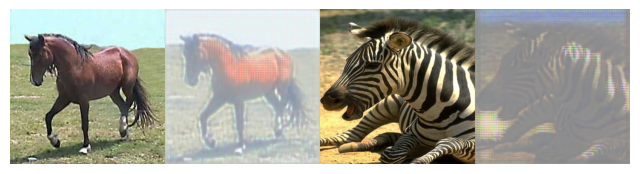

In [5]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
for i in range(len(img_list)):
    img_list[i] = img_list[i].cpu().detach().numpy()
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())